<a href="https://colab.research.google.com/github/ch2ohch2oh/plm-notebooks/blob/main/bert_finetune_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
# os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from datasets import load_dataset

# Load the IMDB dataset
imdb = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
print(imdb)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
from datasets import load_dataset

# Load the IMDB dataset
imdb = load_dataset("imdb")

# Perform a train-test split on the original training dataset
# This will create two splits: 'train' and 'test' from imdb['train']
train_test_split_dataset = imdb["train"].train_test_split(test_size=0.2, seed=42) # Splitting 80% for train and 20% for evaluation

# Assign the splits to small_train_dataset and small_eval_dataset
small_train_dataset = train_test_split_dataset["train"]
small_eval_dataset = train_test_split_dataset["test"]

print("New dataset splits:")
print(small_train_dataset)
print(small_eval_dataset)

New dataset splits:
Dataset({
    features: ['text', 'label'],
    num_rows: 20000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})


In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer for bert-base-uncased
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create a function to tokenize the text
def tokenize_function(examples):
    # padding="max_length" pads sentences to a uniform length.
    # truncation=True ensures sentences longer than the model's max input size are cut down.
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply the tokenizer to the entire dataset using map()
tokenized_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = small_eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertForSequenceClassification

# Load the model for sequence classification with 2 labels
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer

# 1. Define a function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# 2. Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",          # Directory to save the model
    num_train_epochs=10,              # Total number of training epochs
    per_device_train_batch_size=32,   # Batch size for training
    per_device_eval_batch_size=32,    # Batch size for evaluation
    warmup_steps=60,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for storing logs
    logging_steps=10,
    eval_strategy="steps",           # Evaluate every n steps
    eval_steps=100,                  # Perform evaluation every 100 steps (batches)
    report_to=None,
    fp16=True  # This is critical, otherwise it is slow as hell!!
)

In [ ]:
from transformers import Trainer

# Create the Trainer instance with updated training_args
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics,
)

# Start fine-tuning
trainer.train() # Should expect around 1 it/s using colab's Tesla T4 GPU

Step,Training Loss,Validation Loss,Accuracy
100,0.077700,0.294314,0.908600
200,0.072200,0.336977,0.909200
300,0.280100,0.216287,0.911800
400,0.243100,0.215417,0.911400
500,0.155400,0.233120,0.913600
600,0.192600,0.210665,0.921600
700,0.120400,0.281034,0.911600
800,0.111200,0.218524,0.924400
900,0.138800,0.225596,0.924000
1000,0.119900,0.244964,0.920600


KeyboardInterrupt: 

Training in progress...

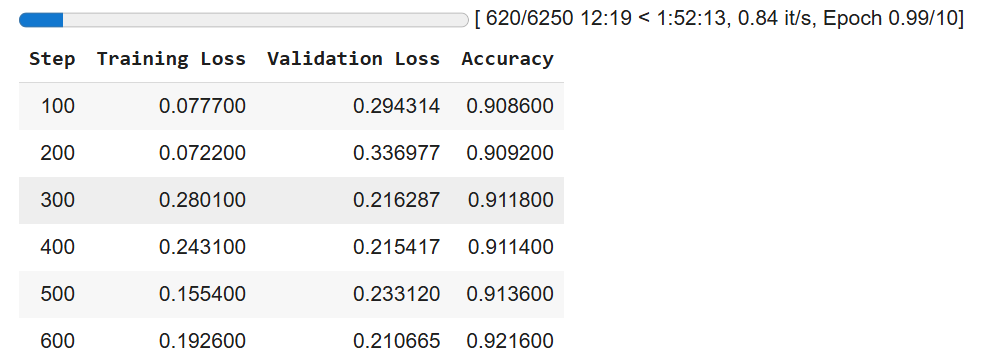